In [ ]:
pip install neo4j

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
from neo4j import GraphDatabase

In [10]:
# 設定連線到 Memgraph，本機默認：bolt://localhost:7687
uri = "bolt://localhost:7687"
# 如果沒有設定使用者驗證，可傳入空字串；如果有設定，請填入相應參數
driver = GraphDatabase.driver(uri, auth=("",""))  

In [11]:
def get_all_nodes(tx):
    # 取得所有節點資訊
    result = tx.run("MATCH (n) RETURN n LIMIT 100")
    return [record["n"] for record in result]

def get_all_relationships(tx):
    # 取得所有邊資訊
    result = tx.run("MATCH ()-[r]->() RETURN r LIMIT 100")
    return [record["r"] for record in result]

with driver.session() as session:
    nodes = session.read_transaction(get_all_nodes)
    relationships = session.read_transaction(get_all_relationships)
    print("Nodes:")
    for n in nodes:
        print(n)
    print("\nRelationships:")
    for r in relationships:
        print(r)

driver.close()

Nodes:
<Node element_id='63' labels=frozenset({'User'}) properties={'id': 1, 'name': 'Alice'}>
<Node element_id='64' labels=frozenset({'User'}) properties={'id': 2, 'name': 'Bob'}>
<Node element_id='65' labels=frozenset({'User'}) properties={'id': 3, 'name': 'Charlie'}>
<Node element_id='66' labels=frozenset({'User'}) properties={'id': 4, 'name': 'Diana'}>
<Node element_id='67' labels=frozenset({'User'}) properties={'id': 5, 'name': 'Eve'}>
<Node element_id='68' labels=frozenset({'Streamer'}) properties={'id': 1, 'name': 'Streamer A'}>
<Node element_id='69' labels=frozenset({'Streamer'}) properties={'id': 2, 'name': 'Streamer B'}>
<Node element_id='70' labels=frozenset({'Item'}) properties={'id': 1, 'name': 'Item 1'}>
<Node element_id='71' labels=frozenset({'Item'}) properties={'id': 2, 'name': 'Item 2'}>
<Node element_id='72' labels=frozenset({'Item'}) properties={'id': 3, 'name': 'Item 3'}>
<Node element_id='73' labels=frozenset({'Item'}) properties={'id': 4, 'name': 'Item 4'}>

Rela

C:\Users\Mattis\AppData\Local\Temp\ipykernel_25772\1529702213.py:12: DeprecationWarning: read_transaction has been renamed to execute_read
  nodes = session.read_transaction(get_all_nodes)
C:\Users\Mattis\AppData\Local\Temp\ipykernel_25772\1529702213.py:13: DeprecationWarning: read_transaction has been renamed to execute_read
  relationships = session.read_transaction(get_all_relationships)


In [1]:
pip uninstall -y dgl

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install dgl==2.0.0 -f https://data.dgl.ai/wheels/cu124/repo.html

Looking in links: https://data.dgl.ai/wheels/cu124/repo.html
     ---------------------------------------- 4.6/4.6 MB 4.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
!pip install torch==2.4.1 torchvision==0.19.1 torchaudio==2.4.1 --index-url https://download.pytorch.org/whl/cu124

Looking in indexes: https://download.pytorch.org/whl/cu124



[notice] A new release of pip available: 22.3 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import torch
import dgl

In [6]:
if torch.cuda.is_available():
    # Set default device to GPU
    device = torch.device("cuda")
    
    # Get details about the GPU
    print("Current GPU device index:", torch.cuda.current_device())
    print("GPU device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    device = torch.device("cpu")

Current GPU device index: 0
GPU device name: NVIDIA GeForce RTX 3050 Laptop GPU


In [12]:
# -----------------------------
# Step 1: 連線到 Memgraph 並提取節點資訊
# -----------------------------
uri = "bolt://localhost:7687"
# 如果你的 Memgraph 沒有設定用戶驗證，auth 參數填 ("", "")
driver = GraphDatabase.driver(uri, auth=("",""))
session = driver.session()

# 提取所有節點，並返回它們的標籤（假設每個節點只有一個主要標籤）與 id 屬性
node_query = "MATCH (n) RETURN labels(n) AS labels, n.id AS id"
result = session.run(node_query)

# 建立一個字典，按標籤（例如 "User", "Streamer", "Item"）存放所有原始的 id
nodes_by_label = {}
for record in result:
    # 假設每個節點都有一個標籤，取第一個
    label_list = record["labels"]
    if not label_list:  # 如果沒有標籤則跳過
        continue
    label = label_list[0]
    node_id = record["id"]
    nodes_by_label.setdefault(label, set()).add(node_id)

# 將每個標籤的原始 id 轉換為有序列表，並建立從原始 id 到內部索引的映射
node_mappings = {}
node_counts = {}
for label, id_set in nodes_by_label.items():
    sorted_ids = sorted(list(id_set))
    mapping = {orig: idx for idx, orig in enumerate(sorted_ids)}
    node_mappings[label] = mapping
    node_counts[label] = len(sorted_ids)

print("各節點類型數量:", node_counts)
# 例如可能輸出：{'User': 5, 'Streamer': 2, 'Item': 4}

各節點類型數量: {'User': 5, 'Streamer': 2, 'Item': 4}


In [13]:
# -----------------------------
# Step 2: 提取邊資訊
# -----------------------------
# 我們這裡定義有三種關係，注意關係的方向與參與節點類型：
#   ('User', 'FOLLOW', 'Streamer')
#   ('Streamer', 'SELL', 'Item')
#   ('User', 'BUY', 'Item')
relationship_types = ["FOLLOW", "SELL", "BUY"]
edges_by_type = {}  # key 格式：(src_label, rel, dst_label)

for rel in relationship_types:
    # 針對每個關係執行查詢
    query = f"""
        MATCH (n)-[r]->(m)
        WHERE type(r) = '{rel}'
        RETURN n.id AS src, m.id AS dst,
               labels(n)[0] AS src_label, labels(m)[0] AS dst_label
    """
    res = session.run(query)
    src_list = []
    dst_list = []
    src_label = None
    dst_label = None
    for record in res:
        src_list.append(record["src"])
        dst_list.append(record["dst"])
        src_label = record["src_label"]
        dst_label = record["dst_label"]
    if src_label is not None and dst_label is not None:
        edges_by_type[(src_label, rel, dst_label)] = (src_list, dst_list)

session.close()
driver.close()

print("邊資訊提取結果:")
for key, (src_list, dst_list) in edges_by_type.items():
    print(key, "->", len(src_list), "條邊")

邊資訊提取結果:
('User', 'FOLLOW', 'Streamer') -> 5 條邊
('Streamer', 'SELL', 'Item') -> 4 條邊
('User', 'BUY', 'Item') -> 3 條邊


In [14]:
# -----------------------------
# Step 3: 利用映射轉換邊資料，組成 DGL 所需格式
# -----------------------------
dgl_data_dict = {}
for (src_label, rel, dst_label), (src_list, dst_list) in edges_by_type.items():
    # 將原始 id 轉成映射後的索引
    mapped_src = [node_mappings[src_label][x] for x in src_list]
    mapped_dst = [node_mappings[dst_label][x] for x in dst_list]
    dgl_data_dict[(src_label, rel, dst_label)] = (
        torch.tensor(mapped_src, dtype=torch.int64),
        torch.tensor(mapped_dst, dtype=torch.int64)
    )

print("建立 DGL 異質圖的資料字典:")
for key, value in dgl_data_dict.items():
    print(key, "->", value[0].shape, value[1].shape)

# -----------------------------
# Step 4: 建構 DGL 異質圖
# -----------------------------
graph = dgl.heterograph(dgl_data_dict, num_nodes_dict=node_counts)
print("成功建立 DGL 異質圖:")
print(graph)
print("各節點型態的數量:", {ntype: graph.num_nodes(ntype) for ntype in graph.ntypes})

# 現在 graph 就包含了從 Memgraph 擷取出來的圖結構，
# 你可以用來訓練 GNN 模型，例如用 HeteroGraphConv 進行鏈接預測、節點分類等任務。

建立 DGL 異質圖的資料字典:
('User', 'FOLLOW', 'Streamer') -> torch.Size([5]) torch.Size([5])
('Streamer', 'SELL', 'Item') -> torch.Size([4]) torch.Size([4])
('User', 'BUY', 'Item') -> torch.Size([3]) torch.Size([3])
成功建立 DGL 異質圖:
Graph(num_nodes={'Item': 4, 'Streamer': 2, 'User': 5},
      num_edges={('Streamer', 'SELL', 'Item'): 4, ('User', 'BUY', 'Item'): 3, ('User', 'FOLLOW', 'Streamer'): 5},
      metagraph=[('Streamer', 'Item', 'SELL'), ('User', 'Item', 'BUY'), ('User', 'Streamer', 'FOLLOW')])
各節點型態的數量: {'Item': 4, 'Streamer': 2, 'User': 5}


In [16]:
pip install matplotlib

     ---------------------------------------- 8.1/8.1 MB 4.3 MB/s eta 0:00:00
  Using cached contourpy-1.3.1-cp311-cp311-win_amd64.whl (219 kB)
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
     ---------------------------------------- 2.2/2.2 MB 10.8 MB/s eta 0:00:00
     ---------------------------------------- 72.0/72.0 kB 3.9 MB/s eta 0:00:00
     -------------------------------------- 111.1/111.1 kB 6.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
pip install networkx

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


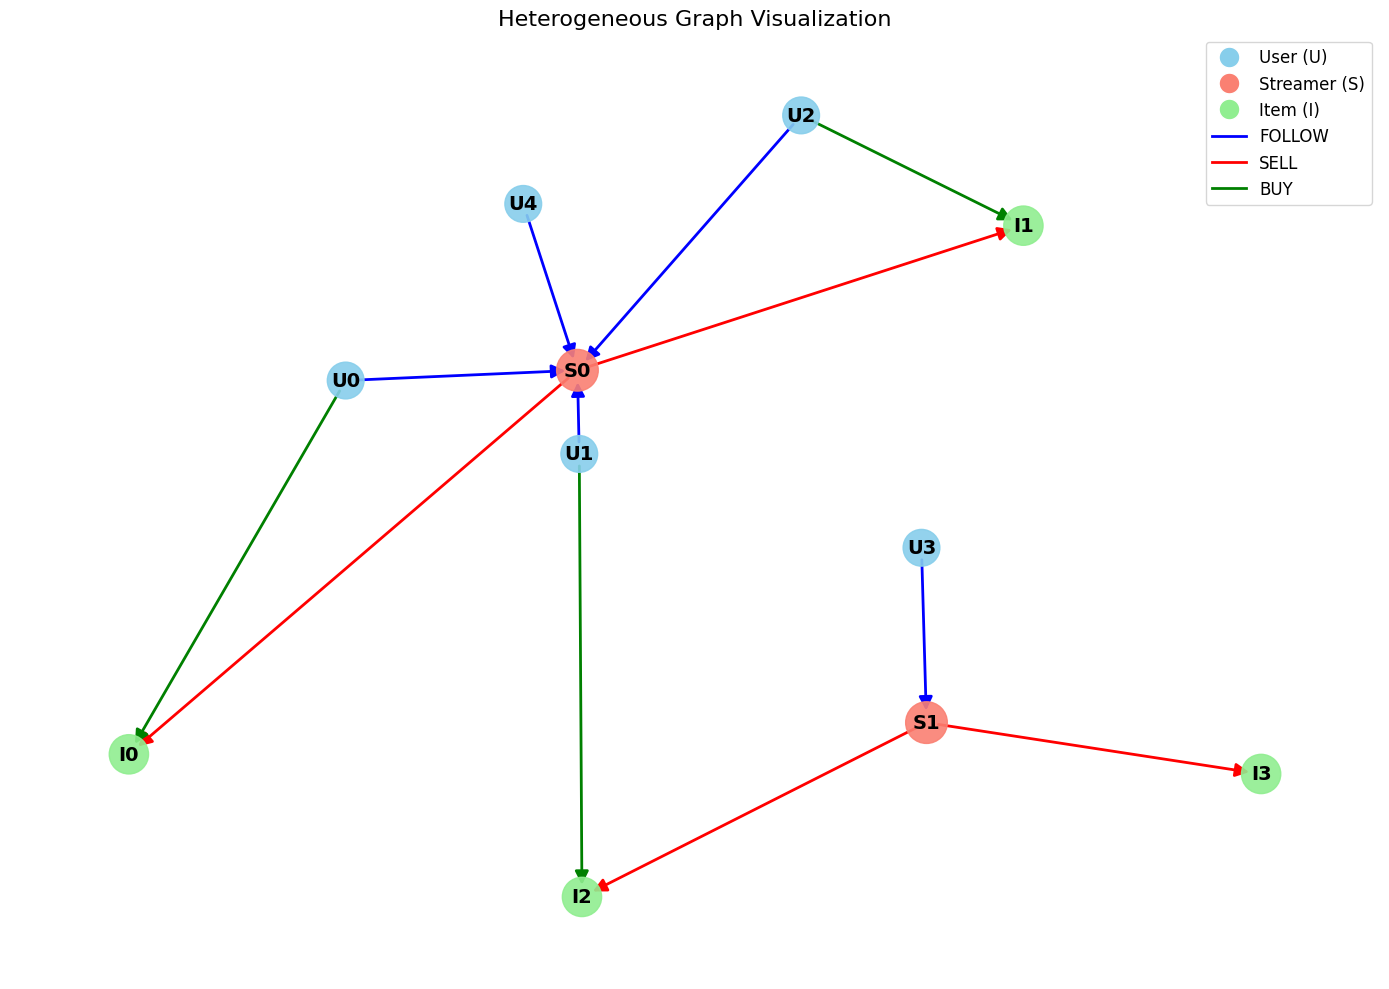

詳細邊關係:
U0 -[FOLLOW]-> S0
U0 -[BUY]-> I0
U1 -[FOLLOW]-> S0
U1 -[BUY]-> I2
U2 -[FOLLOW]-> S0
U2 -[BUY]-> I1
U3 -[FOLLOW]-> S1
U4 -[FOLLOW]-> S0
S0 -[SELL]-> I0
S0 -[SELL]-> I1
S1 -[SELL]-> I2
S1 -[SELL]-> I3


NameError: name 'np' is not defined

In [20]:
# -----------------------------
# 基本資料（從 Memgraph 提取並轉換後得到的資料）
# -----------------------------
num_users = 5      # User 數量
num_streamers = 2  # Streamer 數量
num_items = 4      # Item 數量

# (User, FOLLOW, Streamer) 邊：5 條邊
follow_user = torch.tensor([0, 1, 2, 3, 4], dtype=torch.int64)
follow_streamer = torch.tensor([0, 0, 0, 1, 0], dtype=torch.int64)

# (Streamer, SELL, Item) 邊：4 條邊
sell_streamer = torch.tensor([0, 0, 1, 1], dtype=torch.int64)
sell_item = torch.tensor([0, 1, 2, 3], dtype=torch.int64)

# (User, BUY, Item) 邊：3 條邊
buy_users = [0, 1, 2]    # 已經映射後的 User 索引 (0~4)
buy_items = [0, 2, 1]    # 已經映射後的 Item 索引 (0~3)

# -----------------------------
# 方法一：根據上述數據利用 NetworkX 繪製異質圖
# -----------------------------
def visualize_heterograph():
    # 建立 NetworkX 有向圖
    G = nx.DiGraph()
    
    # 添加節點：以 "U{i}" 表示 User、"S{i}" 表示 Streamer、"I{i}" 表示 Item
    for i in range(num_users):
        G.add_node(f"U{i}", type="User")
    for i in range(num_streamers):
        G.add_node(f"S{i}", type="Streamer")
    for i in range(num_items):
        G.add_node(f"I{i}", type="Item")
    
    # 添加 FOLLOW 邊：User -> Streamer
    for u, s in zip(follow_user.tolist(), follow_streamer.tolist()):
        G.add_edge(f"U{u}", f"S{s}", type="FOLLOW")
    
    # 添加 SELL 邊：Streamer -> Item
    for s, i in zip(sell_streamer.tolist(), sell_item.tolist()):
        G.add_edge(f"S{s}", f"I{i}", type="SELL")
    
    # 添加 BUY 邊：User -> Item
    for u, i in zip(buy_users, buy_items):
        G.add_edge(f"U{u}", f"I{i}", type="BUY")
    
    # 設定節點顏色與大小
    node_colors = []
    node_sizes = []
    for node in G.nodes():
        if node.startswith("U"):
            node_colors.append("skyblue")
            node_sizes.append(700)
        elif node.startswith("S"):
            node_colors.append("salmon")
            node_sizes.append(900)
        elif node.startswith("I"):
            node_colors.append("lightgreen")
            node_sizes.append(800)
        else:
            node_colors.append("gray")
            node_sizes.append(600)
    
    # 利用 Spring layout 計算節點位置，並手動調整 User 與 Item 的垂直位置
    pos = nx.spring_layout(G, k=0.5, iterations=100, seed=42)
    for node in G.nodes():
        if node.startswith("U"):
            pos[node][1] += 0.3
        elif node.startswith("I"):
            pos[node][1] -= 0.3
    
    # 繪製節點
    plt.figure(figsize=(14, 10))
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.9)
    
    # 分離不同類型的邊
    follow_edges = [(u, v) for u, v, d in G.edges(data=True) if d["type"] == "FOLLOW"]
    sell_edges = [(u, v) for u, v, d in G.edges(data=True) if d["type"] == "SELL"]
    buy_edges = [(u, v) for u, v, d in G.edges(data=True) if d["type"] == "BUY"]
    
    # 分別繪製各類邊
    nx.draw_networkx_edges(G, pos, edgelist=follow_edges, edge_color="blue", arrows=True, arrowsize=20, width=2)
    nx.draw_networkx_edges(G, pos, edgelist=sell_edges, edge_color="red", arrows=True, arrowsize=20, width=2)
    nx.draw_networkx_edges(G, pos, edgelist=buy_edges, edge_color="green", arrows=True, arrowsize=20, width=2)
    
    # 繪製標籤
    labels = {node: node for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=14, font_weight="bold")
    
    # 添加圖例
    user_patch = plt.Line2D([0], [0], marker="o", color="w", markerfacecolor="skyblue",
                              markersize=15, label="User (U)")
    streamer_patch = plt.Line2D([0], [0], marker="o", color="w", markerfacecolor="salmon",
                                  markersize=15, label="Streamer (S)")
    item_patch = plt.Line2D([0], [0], marker="o", color="w", markerfacecolor="lightgreen",
                              markersize=15, label="Item (I)")
    follow_line = plt.Line2D([0], [0], color="blue", lw=2, label="FOLLOW")
    sell_line = plt.Line2D([0], [0], color="red", lw=2, label="SELL")
    buy_line = plt.Line2D([0], [0], color="green", lw=2, label="BUY")
    
    plt.legend(handles=[user_patch, streamer_patch, item_patch, follow_line, sell_line, buy_line],
               loc="upper right", fontsize=12)
    
    plt.title("Heterogeneous Graph Visualization", fontsize=16)
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    
    # 列印所有邊關係（方便確認）
    print("詳細邊關係:")
    for u, v, d in G.edges(data=True):
        print(f"{u} -[{d['type']}]-> {v}")

# -----------------------------
# 方法二：繪製關係矩陣視覺化
def plot_relation_matrices():
    # User-Streamer 關係矩陣 (FOLLOW)
    user_streamer_matrix = np.zeros((num_users, num_streamers))
    for u, s in zip(follow_user.tolist(), follow_streamer.tolist()):
        user_streamer_matrix[u, s] = 1
    
    # Streamer-Item 關係矩陣 (SELL)
    streamer_item_matrix = np.zeros((num_streamers, num_items))
    for s, i in zip(sell_streamer.tolist(), sell_item.tolist()):
        streamer_item_matrix[s, i] = 1

    # User-Item 關係矩陣 (BUY)
    user_item_matrix = np.zeros((num_users, num_items))
    for u, i in zip(buy_users, buy_items):
        user_item_matrix[u, i] = 1

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # 畫 User-Streamer (FOLLOW) 矩陣
    axes[0].imshow(user_streamer_matrix, cmap="Blues")
    axes[0].set_title("User-Streamer (FOLLOW)", fontsize=14)
    axes[0].set_xlabel("Streamer ID", fontsize=12)
    axes[0].set_ylabel("User ID", fontsize=12)
    for i in range(num_users):
        for j in range(num_streamers):
            if user_streamer_matrix[i, j] == 1:
                axes[0].text(j, i, "1", ha="center", va="center", color="black")
    axes[0].set_xticks(np.arange(num_streamers))
    axes[0].set_yticks(np.arange(num_users))
    
    # 畫 Streamer-Item (SELL) 矩陣
    axes[1].imshow(streamer_item_matrix, cmap="Reds")
    axes[1].set_title("Streamer-Item (SELL)", fontsize=14)
    axes[1].set_xlabel("Item ID", fontsize=12)
    axes[1].set_ylabel("Streamer ID", fontsize=12)
    for i in range(num_streamers):
        for j in range(num_items):
            if streamer_item_matrix[i, j] == 1:
                axes[1].text(j, i, "1", ha="center", va="center", color="black")
    axes[1].set_xticks(np.arange(num_items))
    axes[1].set_yticks(np.arange(num_streamers))
    
    # 畫 User-Item (BUY) 矩陣
    axes[2].imshow(user_item_matrix, cmap="Greens")
    axes[2].set_title("User-Item (BUY)", fontsize=14)
    axes[2].set_xlabel("Item ID", fontsize=12)
    axes[2].set_ylabel("User ID", fontsize=12)
    for i in range(num_users):
        for j in range(num_items):
            if user_item_matrix[i, j] == 1:
                axes[2].text(j, i, "1", ha="center", va="center", color="black")
    axes[2].set_xticks(np.arange(num_items))
    axes[2].set_yticks(np.arange(num_users))
    
    plt.tight_layout()
    plt.show()

# 執行視覺化
visualize_heterograph()
plot_relation_matrices()
